# Iranian Tweet EDA and Topic Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings('ignore')

### Data Filtering

In [2]:
data = pd.read_csv('data/iranian_tweets.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122936 entries, 0 to 1122935
Data columns (total 31 columns):
tweetid                     1122936 non-null int64
userid                      1122936 non-null object
user_display_name           1122936 non-null object
user_screen_name            1122936 non-null object
user_reported_location      887669 non-null object
user_profile_description    995845 non-null object
user_profile_url            434954 non-null object
follower_count              1122936 non-null int64
following_count             1122936 non-null int64
account_creation_date       1122936 non-null object
account_language            1122936 non-null object
tweet_language              1117307 non-null object
tweet_text                  1122936 non-null object
tweet_time                  1122936 non-null object
tweet_client_name           1100078 non-null object
in_reply_to_tweetid         339350 non-null float64
in_reply_to_userid          440244 non-null object
quoted_twe

In [62]:
data.tweet_time = pd.to_datetime(data.tweet_time)

In [4]:
df = data[['userid','tweet_language','tweet_text','is_retweet','hashtags','tweet_time']]

In [5]:
df = df[(df.is_retweet==False)&(df.tweet_language=='en')]

### Tokenize & Lemmatize, Remove Punctuation

In [6]:
# Tfidf vectorizer takes care of stop words; it's on us to remove links, punctuation (can include in token pattern?)

In [7]:
punc = set(string.punctuation+'‘’…°–—“”')
lem = nltk.stem.WordNetLemmatizer()
twt = TweetTokenizer(reduce_len=True, strip_handles=True)

def tweet_tokenize(tweet):
    tokens = twt.tokenize(tweet)
    no_punc = [token for token in tokens if (token[0] not in punc)]
    no_links = [token for token in no_punc if token[0:4]!='http']
    return no_links

In [8]:
df['tweet_length'] = df.tweet_text.apply(lambda x: len(x))

In [9]:
df.tweet_length.head()

1    102
2    132
5     79
6     81
7    122
Name: tweet_length, dtype: int64

In [10]:
df['tokens'] = df.tweet_text.apply(tweet_tokenize)

In [11]:
df.tokens.values[0:10]

array([list(['An', 'inquiry', 'by', 'congress', 'confirms', 'that', 'ISIS', 'is', 'indeed', 'a', 'CIA', 'creation']),
       list(['CIA', 'predict', 'third', 'terrorist', 'attack', 'after', 'Sidney', 'and', 'Pakiistan', 'in', 'USA', 'in', '3', 'days']),
       list(['why', 'boko', 'haram', 'come', 'europe', 'legally', 'and', 'easily']),
       list(['ISIS', 'militants', 'plan', 'to', 'target', 'Western', 'capitals']),
       list(['Turkish', 'intelligence', 'chief', 'ISIS', 'is', 'a', 'reality', 'and', 'we', 'are', 'optimistic', 'about', 'the', 'future']),
       list(['What', 'would', 'happen', 'to', 'you', 'if', 'you', 'were', 'a', 'political', 'dissent', 'in', 'Saudi', 'Arabia']),
       list(['Saudi', 'embassy', 'in', 'Turkey', 'became', 'a', 'safe', 'haven', 'for', 'ISIL', 'terrorists']),
       list(['We', 'can', 'destroy', 'Israel', 'in', 'less', 'than', '12', 'minutes', 'Pakistani', 'commander']),
       list(['what', 'they', 'will', 'never', 'tell', 'you', 'about', 'Christmas'

In [12]:
df['word_count'] = df.tokens.apply(lambda x: len(x))

In [13]:
df.tweet_text.values[0:3]

array(['@ParkerLampe An inquiry by congress confirms that ISIS is indeed a CIA creation http://t.co/eFRmFwYZTV',
       '@hadeelhmaidi @wordpressdotcom CIA predict third terrorist attack after Sidney and Pakiistan in USA in 3 days http://t.co/IrPx7M223N',
       '@irfhabib why boko haram come europe,legally and easily? http://t.co/on2vzPqEPH'],
      dtype=object)

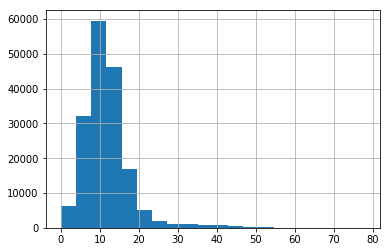

In [14]:
df.word_count.hist(bins=20)

In [15]:
df['word_lengths']=df.tokens.apply(lambda x: [len(i) for i in x])

In [16]:
df.word_lengths.head()

1            [2, 7, 2, 8, 8, 4, 4, 2, 6, 1, 3, 8]
2      [3, 7, 5, 9, 6, 5, 6, 3, 9, 2, 3, 2, 1, 4]
5                        [3, 4, 5, 4, 6, 7, 3, 6]
6                           [4, 9, 4, 2, 6, 7, 8]
7    [7, 12, 5, 4, 2, 1, 7, 3, 2, 3, 10, 5, 3, 6]
Name: word_lengths, dtype: object

## Load and Analyze Politician Tweets

In [17]:
pol_df = pd.read_csv('political_social_media.csv',encoding='iso8859_2')
pol_df = pol_df[pol_df.source=='twitter']
def text_cleanup(tweet):
    tweet = tweet.replace('\x89ŰŞ',"'")
    tweet = tweet.replace('&amp;','&')
    tweet = tweet.replace('\x89Ű_','')
    tweet = tweet.replace('\x89Ű\x9d','')
    tweet = tweet.replace('\x89ŰĎ','')
    tweet = tweet.replace('\x89äĘ','')
    tweet = tweet.replace('\x89Ű\x8f','')
    tweet = tweet.replace('\x89ŰŇ','')
    tweet = tweet.replace('\x89ŰÓ&gt;','')
    tweet = tweet.replace('\x89Ű÷','')
    tweet = tweet.replace("\'","'")
    tweet = tweet.replace("\x89\xa0Ő","")
    tweet = tweet.replace("\x89ŰÓ"," ")
    tweet = tweet.replace("\x89Ű˘\t","")
    tweet = tweet.replace("\x89Ű˘","")    
    return tweet
pol_df['text'] = pol_df.text.apply(text_cleanup)
pol_df['is_retweet'] = pol_df.text.apply(lambda x: 1 if x[0:2]=='RT' else 0)
pol_df['is_quote_tweet'] = pol_df.text.apply(lambda x: 1 if ' RT ' in x else 0)
pol_df = pol_df[(pol_df.is_quote_tweet==0)&(pol_df.is_retweet==0)]

In [18]:
pol_df.text.values[0:10]

array(['VIDEO - #Obamacare:  Full of Higher Costs and Broken Promises: http://t.co/dn3vzqIrWF',
       'Please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices.',
       '.@amazon delivery #drones show need to update law to promote #innovation & protect #privacy. My #UAS bill does that: http://t.co/l9ta5SKq6u',
       'Called on the @USDOTFRA to release info about inspections before the #CasseltonDerailment to review quality of rails. (1/2)',
       "@BBCWorld, help us keep the kidnapped Nigerian school girls' story out front. #BringBackOurGirls #JoinRepWilson http://t.co/ZqZVT80mga",
       'Show your Arizona pride-choose your favorite S. AZ picture for my Facebook cover photo! Retweet to spread the word! https://t.co/7PHHigA8nd',
       "What a wonderful night at State Senator Ken Yager's Chili Supper benefitting the Boys & Girls Clubs of Roane County. http://t.co/DsyoAFZvkR",
       'Great op-ed by Pres.

In [19]:
pol_df['tokens'] = pol_df.text.apply(tweet_tokenize)

In [20]:
pol_df.tokens.values[0:10]

array([list(['VIDEO', 'Full', 'of', 'Higher', 'Costs', 'and', 'Broken', 'Promises']),
       list(['Please', 'join', 'me', 'today', 'in', 'remembering', 'our', 'fallen', 'heroes', 'and', 'honoring', 'the', 'men', 'and', 'women', 'currently', 'in', 'military', 'service', 'for', 'their', 'sacrifices']),
       list(['delivery', 'show', 'need', 'to', 'update', 'law', 'to', 'promote', 'protect', 'My', 'bill', 'does', 'that']),
       list(['Called', 'on', 'the', 'to', 'release', 'info', 'about', 'inspections', 'before', 'the', 'to', 'review', 'quality', 'of', 'rails', '1/2']),
       list(['help', 'us', 'keep', 'the', 'kidnapped', 'Nigerian', 'school', 'girls', 'story', 'out', 'front']),
       list(['Show', 'your', 'Arizona', 'pride-choose', 'your', 'favorite', 'S', 'AZ', 'picture', 'for', 'my', 'Facebook', 'cover', 'photo', 'Retweet', 'to', 'spread', 'the', 'word']),
       list(['What', 'a', 'wonderful', 'night', 'at', 'State', 'Senator', 'Ken', "Yager's", 'Chili', 'Supper', 'benefittin

In [21]:
pol_df['tweet_length'] = pol_df.text.apply(lambda x: len(x))

In [22]:
pol_df['word_count'] = pol_df.tokens.apply(lambda x: len(x))

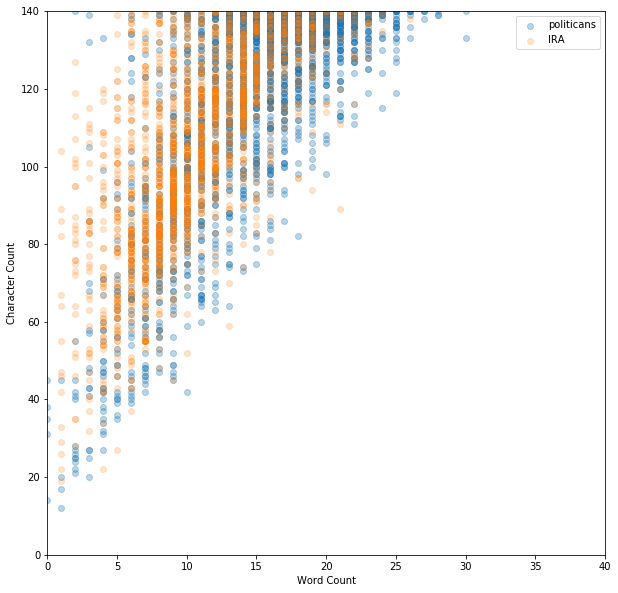

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(pol_df.word_count, pol_df.tweet_length,alpha=0.3, label='politicans')
plt.scatter(df.word_count.iloc[0:2298], df.tweet_length.iloc[0:2298], alpha=0.2, label='IRA')
plt.xlabel('Word Count')
plt.ylabel('Character Count')
plt.ylim(0,140)
plt.xlim(0,40)
plt.legend()

In [24]:
pol_df.shape

(2298, 26)

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(7,7))
ax.flatten()[0].hist(pol_df.word_count, label='politicans',range=(0,30))
ax.flatten()[1].hist(df.word_count.iloc[0:2298], label='Iran', range=(0,30))